In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from tqdm import tqdm,trange

# Set parameters

In [2]:
num_train_examples = 100000
max_train_length = 10

num_test_examples = 10000
min_test_length=5
max_test_length=100
step_test_length=5

# Generate train data

In [3]:
X = np.zeros((num_train_examples,max_train_length))
sum_X = np.zeros((num_train_examples))
for i in tqdm(range(num_train_examples), desc='Generating train examples: '):
    n = np.random.randint(1,max_train_length)
    for j in range(1,n+1):
        X[i,-j] = np.random.randint(1,10)
    sum_X[i] = np.sum(X[i])

Generating train examples: 100%|████████████████████████████████████████████| 100000/100000 [00:02<00:00, 36411.28it/s]


In [4]:
print(X[0:10])
print(sum_X[0:10])

[[0. 0. 0. 0. 0. 0. 1. 8. 7. 5.]
 [0. 0. 0. 7. 6. 7. 4. 2. 3. 1.]
 [0. 0. 0. 0. 5. 7. 9. 3. 5. 7.]
 [0. 0. 0. 0. 0. 0. 6. 5. 6. 4.]
 [0. 0. 0. 0. 0. 0. 0. 9. 9. 3.]
 [0. 0. 0. 0. 0. 0. 8. 2. 6. 1.]
 [0. 9. 3. 1. 6. 4. 1. 2. 5. 5.]
 [0. 0. 0. 0. 0. 4. 8. 7. 4. 6.]
 [0. 0. 0. 0. 0. 0. 0. 2. 9. 7.]
 [0. 7. 6. 7. 1. 9. 2. 6. 9. 2.]]
[21. 30. 36. 21. 21. 17. 36. 29. 18. 49.]


# Generate test data

In [5]:
def gen_test_data(num_examples, length):
    Y = np.zeros((num_examples, length))
    sum_Y = np.zeros((num_examples))
    for i in range(num_examples):
        for j in range(1,length+1):
            Y[i,-j] = np.random.randint(1,10)
        sum_Y[i] = np.sum(Y[i])
    return Y, sum_Y

# DeepSet Model

In [7]:
def get_deepset_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = Dense(30, activation='tanh')(x)
    Adder = Lambda(lambda x: K.sum(x, axis=1), output_shape=(lambda shape: (shape[0], shape[2])))
    x = Adder(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4, epsilon=1e-3)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# LSTM Model

In [8]:
def get_lstm_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = LSTM(50)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# GRU Model

In [9]:
def get_gru_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = GRU(80)(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Vanilla Model

In [10]:
def get_vanilla_model(max_length):
    input_txt = Input(shape=(max_length,))
    x = Embedding(11, 100, mask_zero=True)(input_txt)
    x = Dense(30, activation='tanh')(x)
    x = Dense(20, activation='tanh')(x)
#     x = Dense(30, activation='tanh')(x)
#     x = Reshape((300,))(x)
    encoded = Dense(1)(x)
    summer = Model(input_txt, encoded)
    adam = Adam(lr=1e-4)
    summer.compile(optimizer=adam, loss='mae')
    return summer

# Train Deepset model

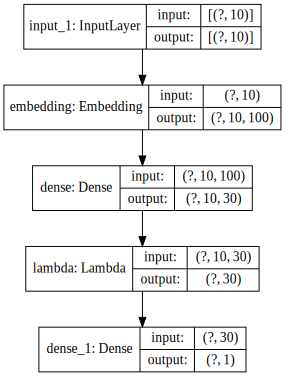

In [11]:
# model
model = get_deepset_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [30]:
# train
# checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=0, save_best_only=True)

# model.fit(X, sum_X, epochs=10, batch_size=128,
#         shuffle=True, validation_split=0.0123456789,
#         callbacks=[checkpointer])

# model = load_model('/tmp/weights.hdf5')

# save weights
deep_we = []
for i in [2]:
    w = model.get_layer(index=i).get_weights()
    print(np.array(w))
    print(np.array(w[0]).shape)
    try:
#         print(np.array(w)[0,0])
        print(np.array(w[1]).shape)
        print(np.array(w[2]).shape)
    except:
        pass
    print(20*"-")
    deep_we.append(w)

[array([[-0.12599632,  0.00077536,  0.2446015 , ..., -0.04846971,
        -0.09065852,  0.2571302 ],
       [-0.01326697,  0.2492257 ,  0.08312345, ...,  0.20712838,
        -0.27303568, -0.10998574],
       [-0.12945433,  0.1181071 , -0.0879201 , ...,  0.23169181,
        -0.03054358,  0.19356827],
       ...,
       [-0.0406423 , -0.1372168 ,  0.10166593, ..., -0.03856798,
        -0.21336192,  0.19098356],
       [-0.1773278 , -0.24902369, -0.08848048, ..., -0.22832353,
        -0.08847812, -0.12399196],
       [ 0.04510212,  0.07408703,  0.07511738, ...,  0.12440398,
         0.13630614,  0.18045159]], dtype=float32)
 array([ 0.03537952,  0.04435851,  0.03892042,  0.03757587, -0.03917359,
       -0.03939283,  0.03485548,  0.041551  , -0.04059435,  0.03202696,
       -0.03400944, -0.04336518, -0.03474866, -0.03297608, -0.03281797,
       -0.03271829,  0.0361113 , -0.03657204,  0.03491117,  0.0343842 ,
        0.03456152,  0.03570298, -0.03687708,  0.03717002, -0.03657369,
        0.

<ipython-input-30-7480ef41c131>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(w))


# Train LSTM model

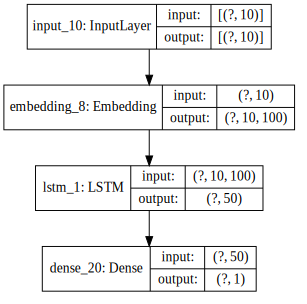

In [39]:
# model
model = get_lstm_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [12]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights1.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights1.hdf5')

# save weights
lstm_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    lstm_we.append(w)

Epoch 1/50
772/772 [==============================] - 9s 12ms/step - loss: 17.7650 - val_loss: 13.0691
Epoch 2/50
772/772 [==============================] - 8s 11ms/step - loss: 11.6705 - val_loss: 10.3118
Epoch 3/50
772/772 [==============================] - 8s 11ms/step - loss: 9.2401 - val_loss: 8.0990
Epoch 4/50
772/772 [==============================] - 8s 11ms/step - loss: 7.1928 - val_loss: 6.3142
Epoch 5/50
772/772 [==============================] - 9s 12ms/step - loss: 5.5650 - val_loss: 4.8083
Epoch 6/50
772/772 [==============================] - 9s 12ms/step - loss: 4.1435 - val_loss: 3.4984
Epoch 7/50
772/772 [==============================] - 8s 10ms/step - loss: 3.0237 - val_loss: 2.5291
Epoch 8/50
772/772 [==============================] - 9s 12ms/step - loss: 2.1837 - val_loss: 1.8196
Epoch 9/50
772/772 [==============================] - 9s 12ms/step - loss: 1.5686 - val_loss: 1.2882
Epoch 10/50
772/772 [==============================] - 8s 11ms/step - loss: 1.1239 - va

# Train GRU model

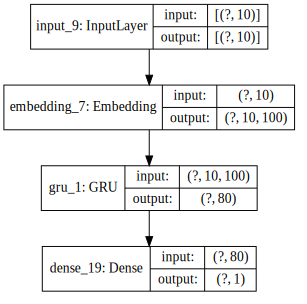

In [38]:
# model
model = get_gru_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [26]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
gru_we = []
for i in [1,2,3]:
    w = model.get_layer(index=i).get_weights()
    gru_we.append(w)

Epoch 1/50
772/772 [==============================] - 15s 19ms/step - loss: 14.8358 - val_loss: 10.0053
Epoch 2/50
772/772 [==============================] - 12s 15ms/step - loss: 8.3423 - val_loss: 6.8427
Epoch 3/50
772/772 [==============================] - 11s 15ms/step - loss: 5.5648 - val_loss: 4.2778
Epoch 4/50
772/772 [==============================] - 11s 14ms/step - loss: 3.3439 - val_loss: 2.5080
Epoch 5/50
772/772 [==============================] - 11s 14ms/step - loss: 1.9986 - val_loss: 1.5132
Epoch 6/50
772/772 [==============================] - 12s 16ms/step - loss: 1.2171 - val_loss: 0.9042
Epoch 7/50
772/772 [==============================] - 11s 15ms/step - loss: 0.7577 - val_loss: 0.5657
Epoch 8/50
772/772 [==============================] - 11s 14ms/step - loss: 0.4976 - val_loss: 0.3921
Epoch 9/50
772/772 [==============================] - 13s 16ms/step - loss: 0.3432 - val_loss: 0.2548
Epoch 10/50
772/772 [==============================] - 13s 17ms/step - loss: 0.2

# Train Vanilla Model

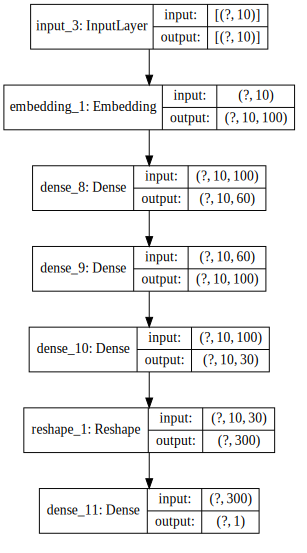

In [89]:
# model
model = get_vanilla_model(max_train_length)

# visualize
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [90]:
# train
checkpointer = ModelCheckpoint(filepath='/tmp/weights2.hdf5', verbose=0, save_best_only=True)

model.fit(X, sum_X, epochs=50, batch_size=128,
        shuffle=True, validation_split=0.0123456789,
        callbacks=[checkpointer])

model = load_model('/tmp/weights2.hdf5')

# save weights
vanilla_we = []
for i in [1,2,3,4]:
    w = model.get_layer(index=i).get_weights()
    vanilla_we.append(w)

Epoch 1/50
772/772 [==============================] - 4s 5ms/step - loss: 14.2989 - val_loss: 7.7997
Epoch 2/50
772/772 [==============================] - 4s 5ms/step - loss: 5.3280 - val_loss: 4.6946
Epoch 3/50
772/772 [==============================] - 3s 4ms/step - loss: 3.1814 - val_loss: 2.0944
Epoch 4/50
772/772 [==============================] - 3s 4ms/step - loss: 1.4240 - val_loss: 0.8963
Epoch 5/50
772/772 [==============================] - 3s 4ms/step - loss: 0.6233 - val_loss: 0.3817
Epoch 6/50
772/772 [==============================] - 3s 4ms/step - loss: 0.2859 - val_loss: 0.2140
Epoch 7/50
772/772 [==============================] - 3s 4ms/step - loss: 0.1759 - val_loss: 0.1326
Epoch 8/50
772/772 [==============================] - 4s 5ms/step - loss: 0.1237 - val_loss: 0.0911
Epoch 9/50
772/772 [==============================] - 3s 5ms/step - loss: 0.0915 - val_loss: 0.0705
Epoch 10/50
772/772 [==============================] - 3s 4ms/step - loss: 0.0743 - val_loss: 0.058

# Evaluate models

In [67]:
metrics = {'deepsets': {'acc':[], 'mae':[], 'mse':[]}, 'lstm': {'acc':[], 'mae':[], 'mse':[]}, 'gru': {'acc':[], 'mae':[], 'mse':[]}, 'vanilla': {'acc':[], 'mae':[], 'mse':[]}}

lengths = range(min_test_length, max_test_length, step_test_length)
for l in lengths:
    print('Evaluating at length: ', l)
    K.clear_session()
    
    # generate test data
    Y, sum_Y = gen_test_data(num_test_examples, l)

    # model
    model = get_deepset_model(l)

    # load weights
    for i, idx in enumerate([1,2,4]):
        model.get_layer(index=idx).set_weights(deep_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['deepsets']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['deepsets']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['deepsets']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_lstm_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(lstm_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['lstm']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['lstm']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['lstm']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    
    # model
    model = get_gru_model(l)

    # load weights
    for i, idx in enumerate([1,2,3]):
        model.get_layer(index=idx).set_weights(gru_we[i])

    # prediction
    preds = model.predict(Y, batch_size=128, verbose=1)
    metrics['gru']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
    metrics['gru']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
    metrics['gru']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))
    

In [91]:
print('Evaluating at length: ', 10)
K.clear_session()

# generate test data
Y, sum_Y = gen_test_data(num_test_examples, 10)

# model
model = get_vanilla_model(10)

# load weights
for i, idx in enumerate([1,2,3]):
    model.get_layer(index=idx).set_weights(vanilla_we[i])

# prediction
preds = model.predict(Y, batch_size=128, verbose=1)
metrics['vanilla']['acc'].append(1.0*np.sum(np.squeeze(np.round(preds))==sum_Y)/len(sum_Y))
metrics['vanilla']['mae'].append(np.sum(np.abs(np.squeeze(preds)-sum_Y))/len(sum_Y))
metrics['vanilla']['mse'].append(np.dot(np.squeeze(preds)-sum_Y, np.squeeze(preds)-sum_Y)/len(sum_Y))

Evaluating at length:  10
79/79 [==============================] - 0s 3ms/step


Compare the performance

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0]


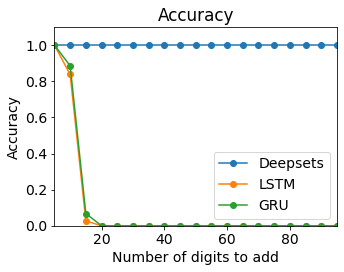

In [93]:
font = {'size': 14}
matplotlib.rc('font', **font)

scale = 0.5
plt.figure(figsize=(10*scale, 8*scale))
print(metrics['deepsets']['acc'])
plt.plot(lengths, metrics['deepsets']['acc'], 'o-')
plt.plot(lengths, metrics['lstm']['acc'], 'o-')
plt.plot(lengths, metrics['gru']['acc'], 'o-')
print(metrics['vanilla']['acc'])
plt.xlabel('Number of digits to add')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.ylim( 0, 1.1 )
plt.xlim( 5, 95 )
plt.legend(['Deepsets', 'LSTM', 'GRU'], fontsize=14)
plt.tight_layout()
plt.show()